# Overview

* Table of contents (with links)
* Introduction
* Purpose of the notebook
* Key steps (include a picture)
   * Step 0: Initialize Session
   * Step 1: View Past Forecasts
   * Step 2: Examine Data
   * Step 3: Build Model and Generate Forecasts
   * Step 4: Planning & What-if Scenarios
   * Step 5: Review Outputs
   * Step 6: Publish Current Forecast Outputs
* Organization of the notebook
   * Each of the above steps has the following components 
       * Description of the step,
       * Tips on input parameter choices
       * Code cells (edit, edit- only by expert users, no edit) 
       * Tips on interpreting outputs and troubleshooting
* Prerequisites for running the notebook
* Additional resources

## Imports 

In [1]:
%load_ext autoreload
%autoreload 2

from model_building_utils_new import ModelBuildingSession

# Step 0: Set Session variables

* **Description**: Creates a session object to track session level variables that do not have to be repeated and sets up the default model building configuration as well as logging of outputs

* **Inputs**: 
    * session_name: str, optional
        * Session name to be used for tracking in MLFlow or logs, otherwise default will be constructed from username and  timestamp (default = user name + timestamp)
    * user_name: str, optional
        * User name will be used for creating session_name if unspecified (default ='guest')
        
* **Outputs**:
    * curr_session: ModelBuildingSession
        * Session object loaded with the default model building configuration
        

### Input Choice Tips

* **session_name** : Pick a name that combines the key elements(region, train interval, runday)

In [2]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# OPTIONAL PARAMETERS
user_name = 'guest'
session_name = 'del'

In [3]:
# NO EDIT CELL
current_session = ModelBuildingSession.create_session(session_name,user_name)

../outputs/del_outputs already exists. Your content might get overwritten.Please change the directory name to retain previous content
**********************
Created session: del
User: guest
Output stored in the directory: ../outputs/del_outputs
**********************



### Output Interpretation & Troubleshooting

* Parameters of the ModelBuildingSession can be examined and set using get_params(), set_params() methods. See the documentation on <TODO:AddLinks> ModelBuildingSession class
* [ML Flow Tracking](https://mlflow.org/docs/latest/tracking.html#tracking) is an open source platform that enables tracking of experiments. Each model building session is logged as a run along with the associated meta data and artifacts 
* The local folder session_name + "_ " outputs/ will contain all the output artifacts associated with the current session. If a function generating artifacts is rerun without changing the artifact filepaths, then they will get overwritten. 
* To start a new run, we have to create a new session by running the above cell again with a new session_name 

# Step 1: View Past Forecasts

* **Description**: Returns links to previously generated forecasts for the specified region

* **Inputs**: 
   * region_type: REGION_TYPE
       * valid region type from ['country','state','district','other']
   * region_name: REGION_NAME
       * valid region name
   * experiment_name: EXPERIMENT_NAME
       * valid experiment name (default: SEIHRD_ENSEMBLE_V0)
   * interval_to_consider: int, optional
       * number of past days to consider for retrieving runs (default =0)
       
* **Outputs**:
    * run_links: list[URL]
        * list of URLs corresponding to relevant "published" ML-Flow links (for now returns a pandas df containing links)

### Input Choice Tips

* **region_type**: 'other' can be used for smaller regions or stratification by some groups (e.g., slums in a region) along with 'csv' source
* **region_name**: Please make sure the spelling and the case of the region_name is correct. Here is a list <TODO:ADDLinks> of valid regions.
* **interval_to_consider**: It is useful to look at the data trends/model parameters from at least one  earlier forecast and contrast that with the current one. 

In [4]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# MANDATORY PARAMETERS
current_session.set_field('region_name', 'delhi')
current_session.set_field('region_type', 'state')

# OPTIONAL PARAMETERS
current_session.set_field('interval_to_consider',50)

In [5]:
# NO EDIT CELL
current_session.view_forecasts()

,Published on,Run name,Link to run
1,2020-07-17,Ensemble testing,http://ec2-54-175-207-176.compute-1.amazonaws.com/#/experiments/7/runs/89dd136b458b4852a5088551f4301da4
2,2020-07-17,Ensemble testing,http://ec2-54-175-207-176.compute-1.amazonaws.com/#/experiments/7/runs/31267e9d03e94a64af307b0a43ba8356
3,2020-07-17,Ensemble testing,http://ec2-54-175-207-176.compute-1.amazonaws.com/#/experiments/7/runs/59d1a51bf5924fb3bd9ea0a47feee95a


### Output Interpretation & Troubleshooting

*  <TODO:ADD> 

# Step 2: Examine Data

* **Description**: Obtains case count data for specified region and displays it 
    as a table and a plot, and writes out the plot as specified 

* **Inputs**: 
    * region_type: REGION_TYPE
        * valid region type from ['country','state','district']
    * region_name: REGION_NAME
        * valid region name
    * data_source_type: DATA_SOURCE_TYPE
        * valid source type from ['official','tracker','csv']
    * data_filepath: str, optional
        * valid local file path of csv file to be uploaded, required only for 'csv' source  
    * case_cnt_plot_file_name: str, optional
        * file_path where the plot file will be written (default ="case_cnt_data_observed.png")
    * case_cnt_csv_file_name: str, optional
        * file_path for output of a standard csv with date and CARD variables (default ="case_cnt_data.csv")
        
* **Outputs**:
    * case_cnt_data: pandas.DataFrame
        * dataframe in a standard format with date and CARD variables

### Input Choice Tips

* There is no need to set parameters that are already set (e.g., region_name) 
* It is preferable to allow output artifact filepaths (e.g., case_cnt_plot_file_name) to also remain as defaults unless there is specific requirement
* **data_filepath**  needs to be set only when the source is csv. 
* Sanity checking has to be done externally for now

In [6]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# ALREADY SET PARAMETERS
#current_session.set_field('region_type', <user_input:region_type>)
#current_session.set_field('region_name', <user_input:region_name>)

# MANDATORY PARAMETERS
current_session.set_field('data_source', 'direct_csv')
current_session.set_field('input_data_file', '/Users/nayana/projects/covid/covid19-india/data/pune.csv')


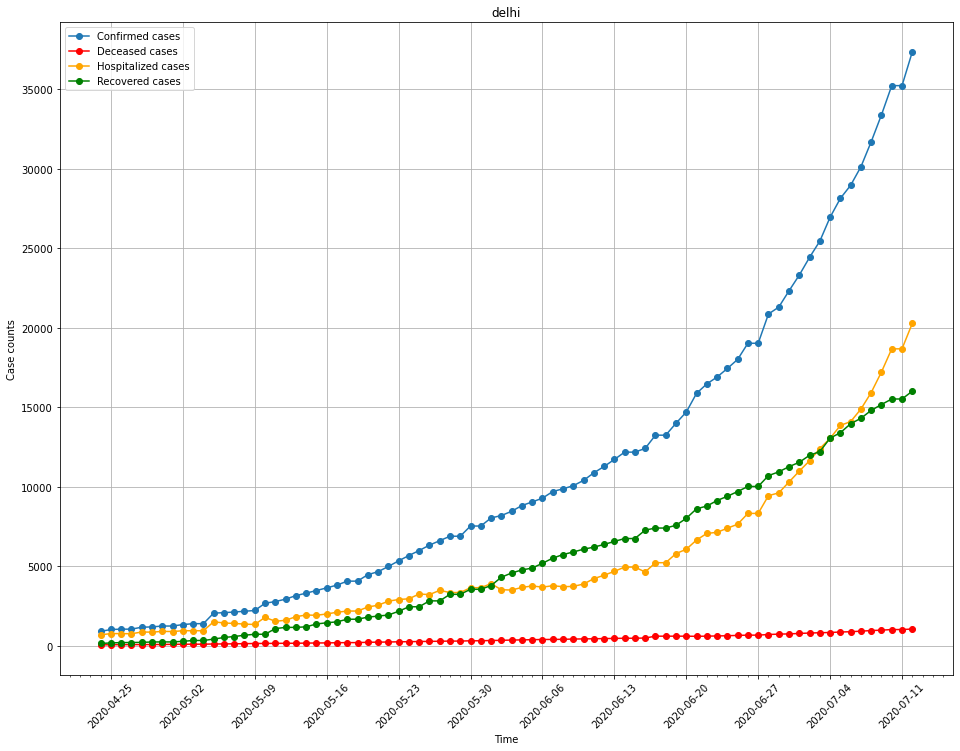

In [7]:
# NO EDIT CELL
current_session.examine_data()

### Output Interpretation & Troubleshooting

* Examine the plot for basic data sanity checks
    * Are all numbers non-negative?
    * Are C,R,D monotonically increasing ?
    * Are there flat regions indicating no data updates for this period ?
    * Is there discontinuous behavior (arbitrary spikes) requiring rolling average smoothing?
    * Are there dates with missing observations? 
* From the output data frame, more checks can be performed
    * Is C=A+R+D ?
* Decide on training and forecast periods 
    * What is a stable recent period from which can be used for building the new models
    * Is the forecast period likely to follow the behavior of the stable training period?
* Decide on which variables are reliable to determine the relative weights in loss function
    * Are there any spikes that make recoveries or deaths unreliable in some regions ?
    

# Step 3: Build Models  & Generate Forecasts

* **Description**: Build models as per the specified configuration, generate train, evaluation reports and also forecasts

* **Inputs**: 
    * region_type: REGION_TYPE
        * valid region type from ['country','state','district']
    * region_name: REGION_NAME
        * valid region name
    * data_source_type: DATA_SOURCE_TYPE
        * valid source type from ['official','tracker','csv']
    * data_filepath: str
        * valid local file path of csv file to be uploaded
    * time_interval_config: TrainTestForecastDatesConfig
        * dates to be used for training, evaluation and forecast
        * see <TODO:add links> for more details (default =mb.TRAIN_TEST_FORECAST_CONFIG)
    * model_class: MODEL_CLASS, optional
        * valid model class in mb.MODEL_CLASS (default ='SEIHRD')
    * num_trials: int, optional
        * number of trials to be used for training (default ='1000')
    * param_searchspace_config: ParamSearchSpaceConfig, optional
        * search space limits, default values and fine-tunability of various configurations
        * see <TODO:add links> for more details (default =mb.PARAM_SEARCHSPACE_CONFIG)
    * train_loss_function_config: LossFunctionConfig, optional
        * relative weighting of CARD variables & loss metric to be used for training
        * see <TODO:add links> for more details (default =mb.TRAIN_LOSS_FUNCTION_CONFIG)
    * eval_loss_function_config: list[LossFunctionConfig], optional
        * all the loss functions required for evaluation
        * see <TODO:add links> for more details (default =mb.EVAL_LOSS_FUNCTION_CONFIG)       
    * forecast_percentiles: list[float], optional
        * list of percentiles that need to be forecast    
    * detailed_report_file: str, optional
        * filepath for the detailed report of the model building run
    * summary_report_file: str, optional
        * filepath for the summary report of the model building run
    * planning_input_report_file: str, optional
        * filepath for the report that contains inputs needed for the planning step 
    
* **Outputs**:
    * model_building_params: dict
        * flattened dict of input configuration used for the model building run
    * model_building_metrics: dict
        * flattened dict of output metrics from the model building run
    * model_building_artifact_list: list[str]
        * list of artifact files (e.g., jsons, plots, csvs, reports) generated

### Input Choice Tips
* As before, there should really be no need to set parameters that are already set even though they are presented again
* There is also no need to change the output artifact filepaths
* This step **does not have*** any mandatory inputs.  
* **Typical User Setup**: 
    * **Relative weights of the variables:**
        * If all the variables C, A, R, D are reliable and equally important for forecast accuracy, then we would wish to give equal weightage  to all of them. 
        * Note that, C, R and D are the independently observed variables and A is derived as A = C-R-D.  Skipping any one of the variables will still provide the same fits.
        * Depending on the application or the modeling purpose, a certain variable, e.g., active cases (A) might be more important than the others and a higher relative weight would be appropriate in that case
        * If any of the independent variables (e.g., recoveries R) is not reliable because of spikes or unlikely values, then it is preferable to just fit to the two other independent variables or at least adjust the relative weights accordingly
    * **Forecast planning variable:**
        * This is the variable that is primarily used for forecast planning and uncertainty estimation (default is Active case count A).
    * **Dates for training, evaluation and forecasting:**
        * **train_end_date**: chosen to be the latest date for which reliable data is available (default choice is d = previous day)
        * **train_start_date**: chosen to be the earliest date since which observations can be used for the current analysis (default choice is  d-14 ). Due to govt policy and public behavior changes, the dynamics themselves are continuously evolving and it is preferable to keep this window small, but at the same adequate to estimate the model parameters in a relatively robust way. 
         * **backtesting_split_date**: chosen to be the date (default choice is d-7) that can be used to split the train period into two intervals, where the first interval is used for training the model that can be used for evaluation on the later interval. The later interval is then used to retrain the model used for forecasting. This process is described in more detail in Model Building Methodology<TODO:AddLinks>. 
         * **forecast_start_date**: chosen to be the date starting from which we need the forecast (default choice is the d'= next day)
         * **forecast_end_date**: chosen to be the date till which we need the forecast (default choice is d'+30)
         * **forecast_planning _date**: chosen to be the date to be used for medical planning and percentile calculations (default choice is the d'+15) 

* **Expert User Setup**: 
    * If required, experts familiar with epidemiological parameters can also play around with the default model parameters and training search space. All the model building parameters, default values and the relevant information for finetuning these are listed in ModelBuildingParameters <TODO:ADDLinks>

In [8]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# ALREADY SET PARAMETERS
#current_session.set_param('region_type', <user_input:region_type>)
#current_session.set_param('region_name', <user_input:region_name>)
#current_session.set_param('data_source_type', <user_input:data_source_type>)
#current_session.set_param('data_filepath', <user_input:data_filepath>)

# MANDATORY PARAMETERS - NONE

# OPTIONAL PARAMETERS
# Loss function - relative weights of variables
current_session.set_field('train_loss_function.C_weight', 0.25)
current_session.set_field('train_loss_function.A_weight', 0.25)
current_session.set_field('train_loss_function.R_weight', 0.25)
current_session.set_field('train_loss_function.D_weight', 0.25)

# Primary variable for forecast planning
current_session.set_field('uncertainty_parameters.variable_of_interest', 'confirmed')

# Dates for train, eval, forecast and planning 

current_session.set_field('time_interval_config.offset_based.reference_day', '7/12/20')
current_session.set_field('time_interval_config.offset_based.train_period', 14)
current_session.set_field('time_interval_config.offset_based.test_period', 7)
current_session.set_field('time_interval_config.offset_based.forecast_period', 30)
current_session.set_field('uncertainty_parameters.date_of_interest', '7/25/20')

In [9]:
# EXPERT USER SET UP (PLEASE DO NOT EDIT UNLESS REALLY REQUIRED)
# EDIT CELL:

# OPTIONAL PARAMETERS FOR EXPERTS
# Any input parameter of build_models_and_generate_forecasts in ModelBuildingParameter.pdf can be adjusted similar to below example 

#current_session.set_param('param_searchspace_config.R_t.default_value',<user_input:param_searchspace_config.R_t.default_value>)


100%|██████████| 10/10 [00:00<00:00, 24.15trial/s, best loss: 0.0]
Best fit: {'beta': 7.550299926921511}
Best Loss: 0.0
100%|██████████| 10/10 [00:00<00:00, 50.28trial/s, best loss: 0.0]
Best fit: {'beta': 9.69995610578166}
Best Loss: 0.0


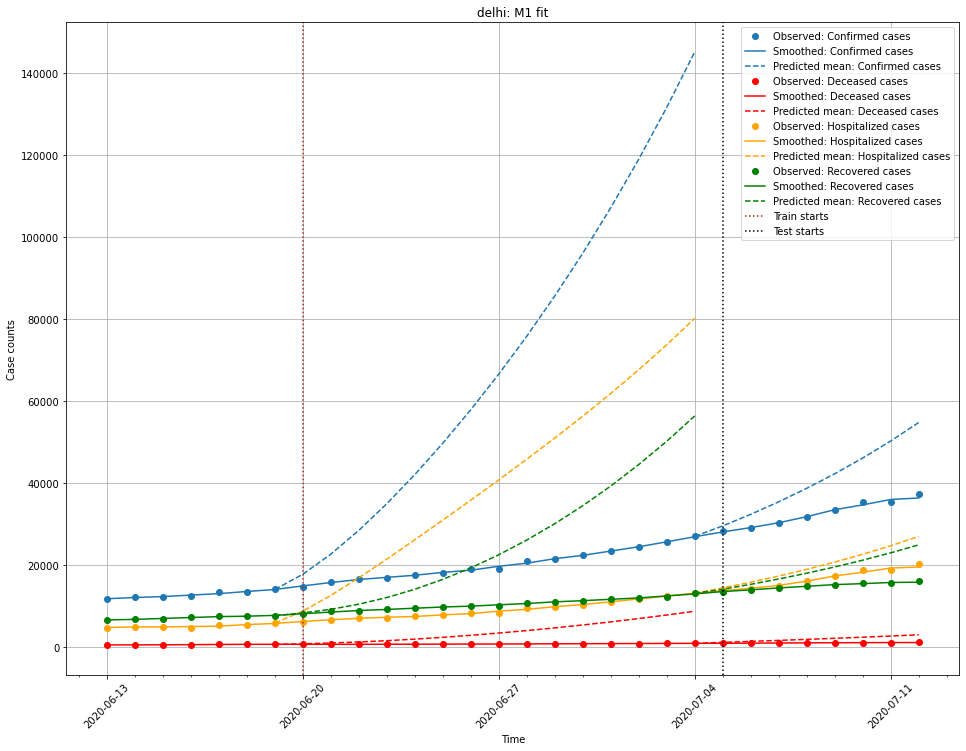

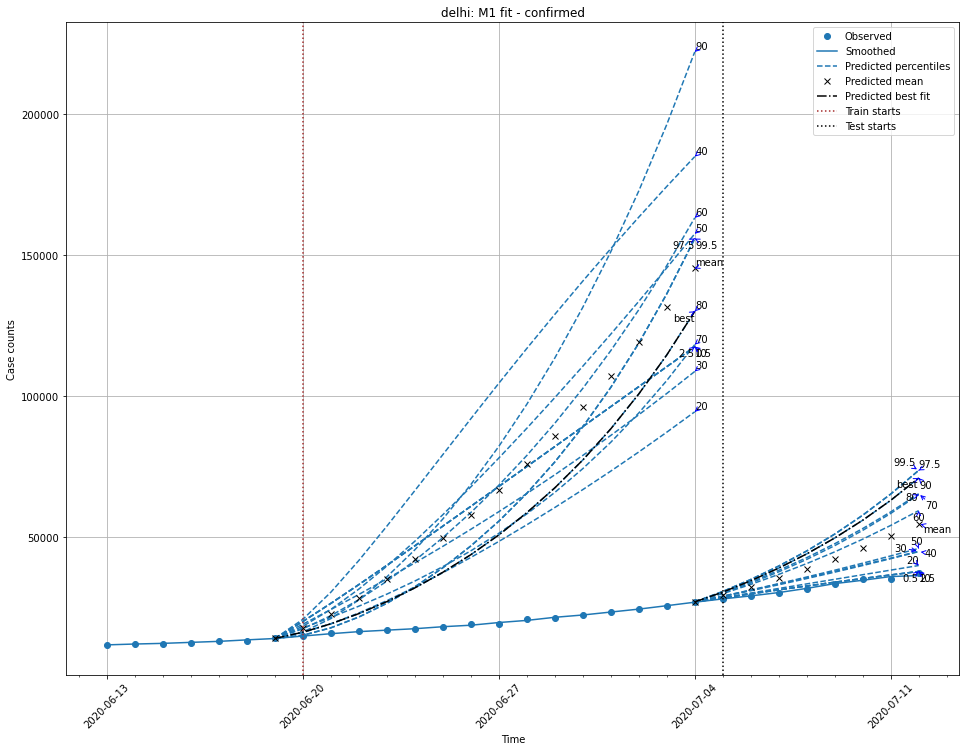

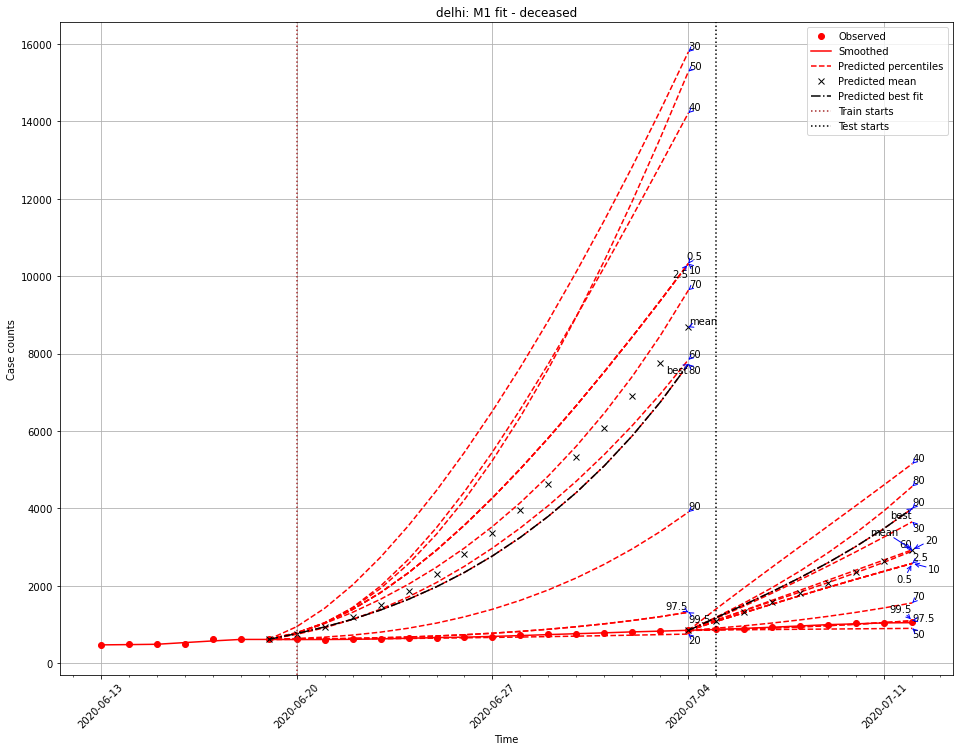

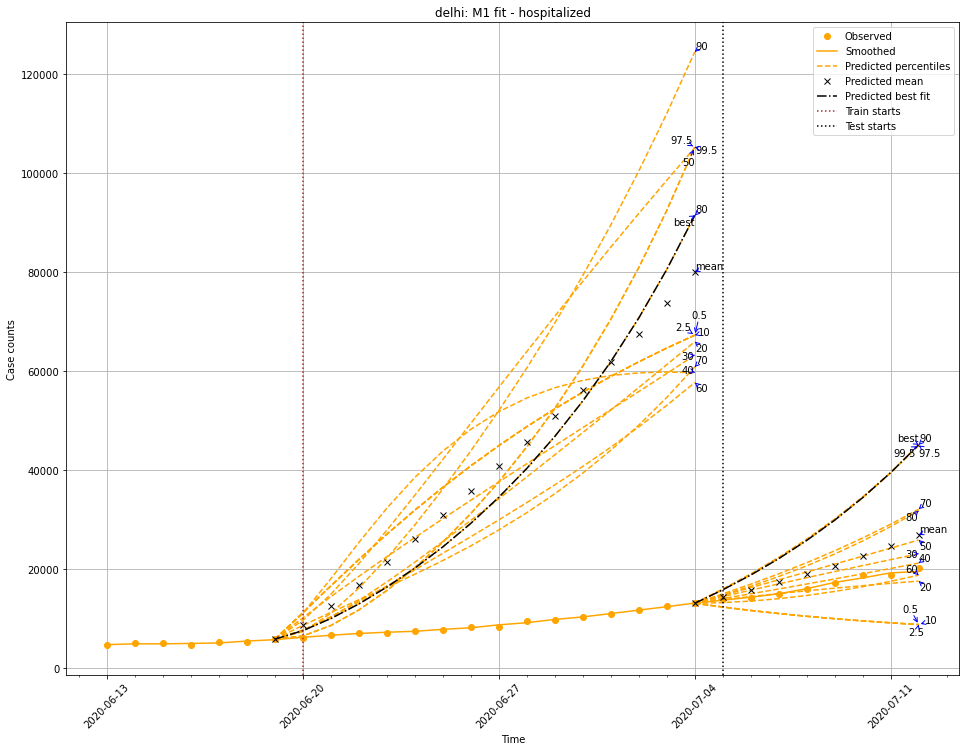

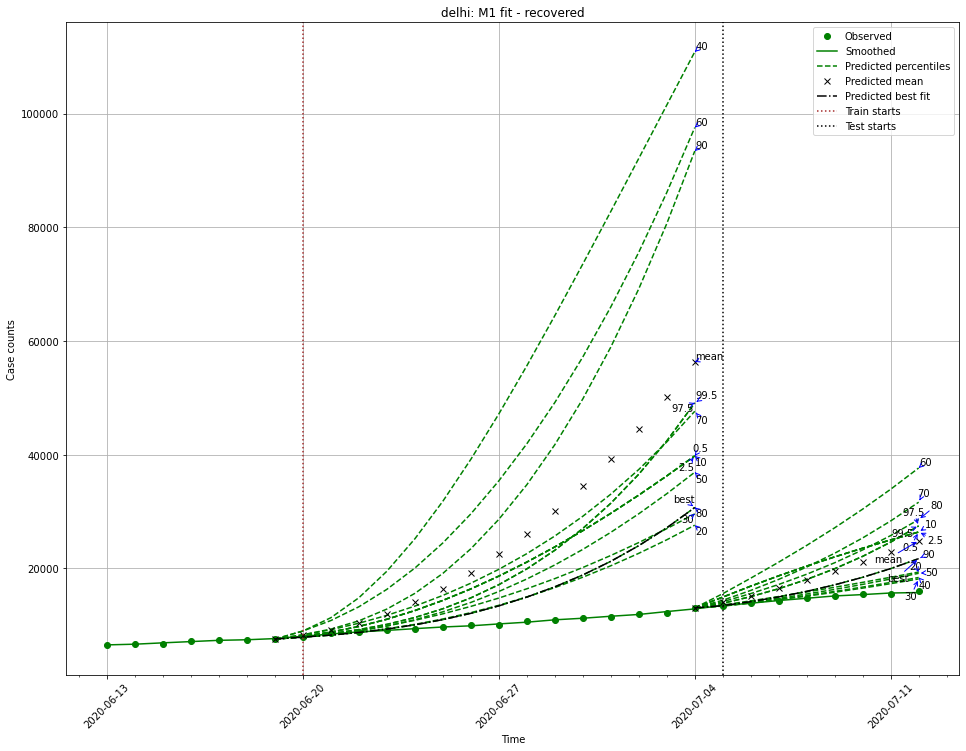

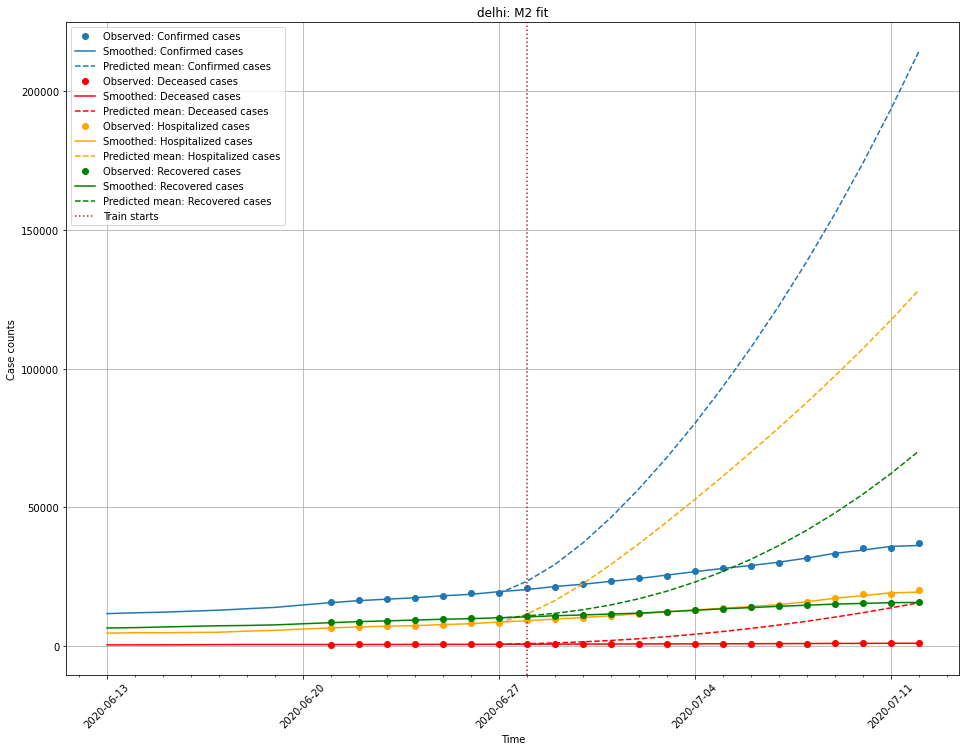

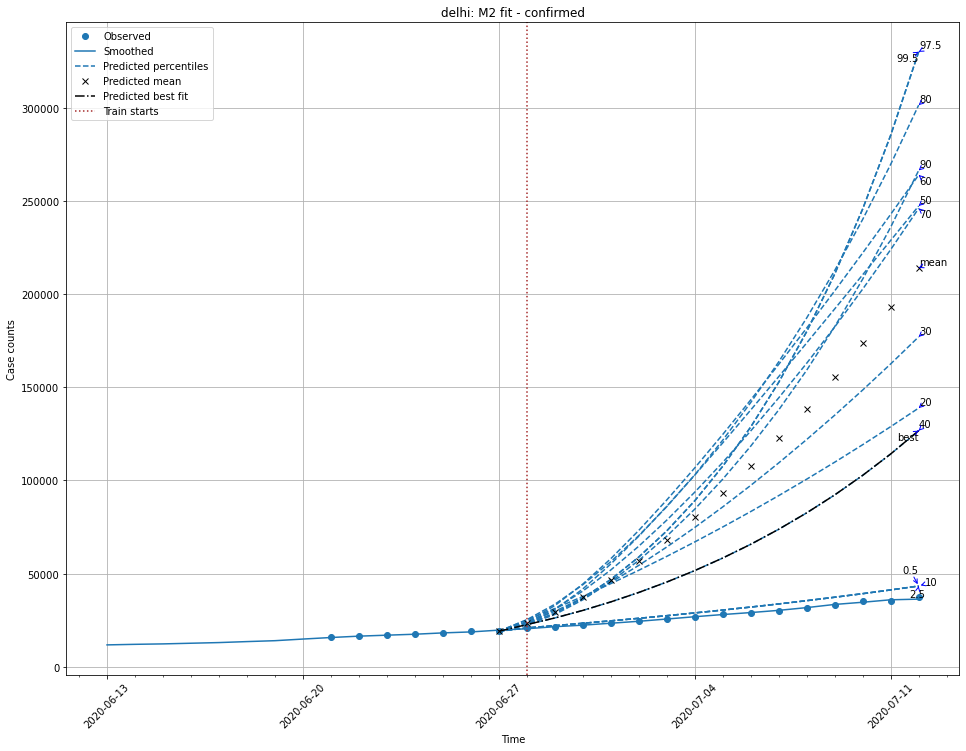

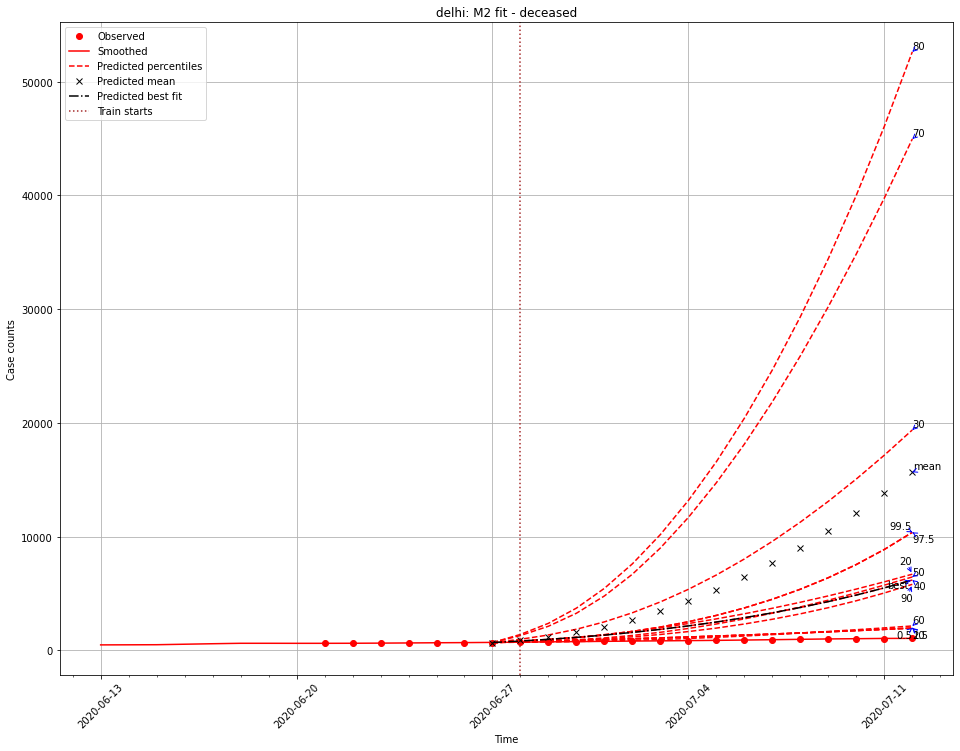

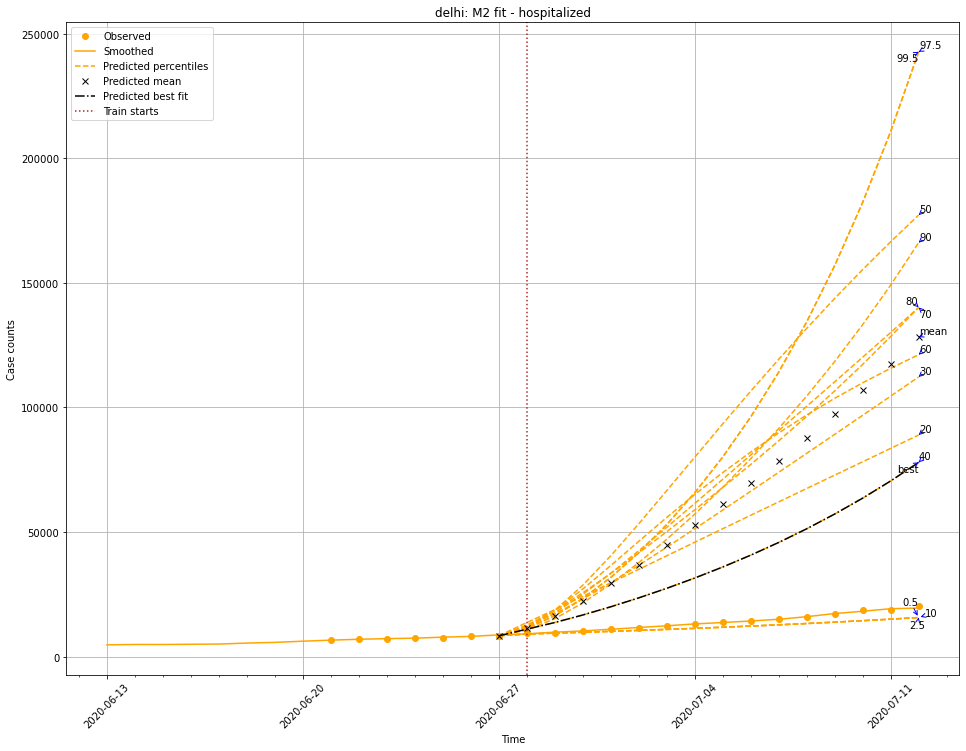

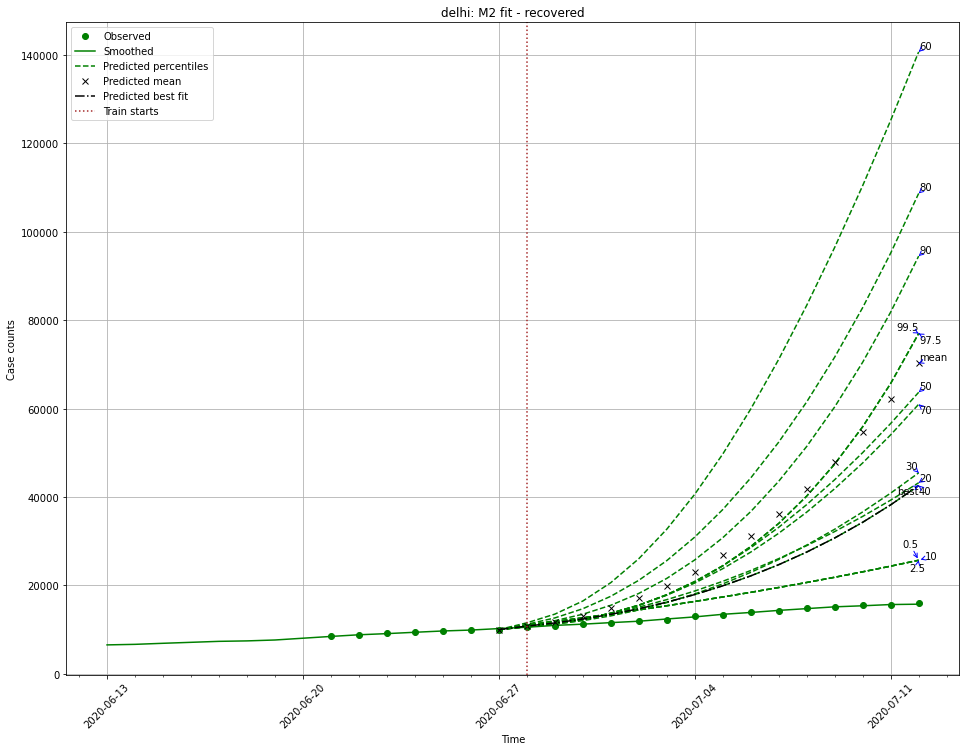

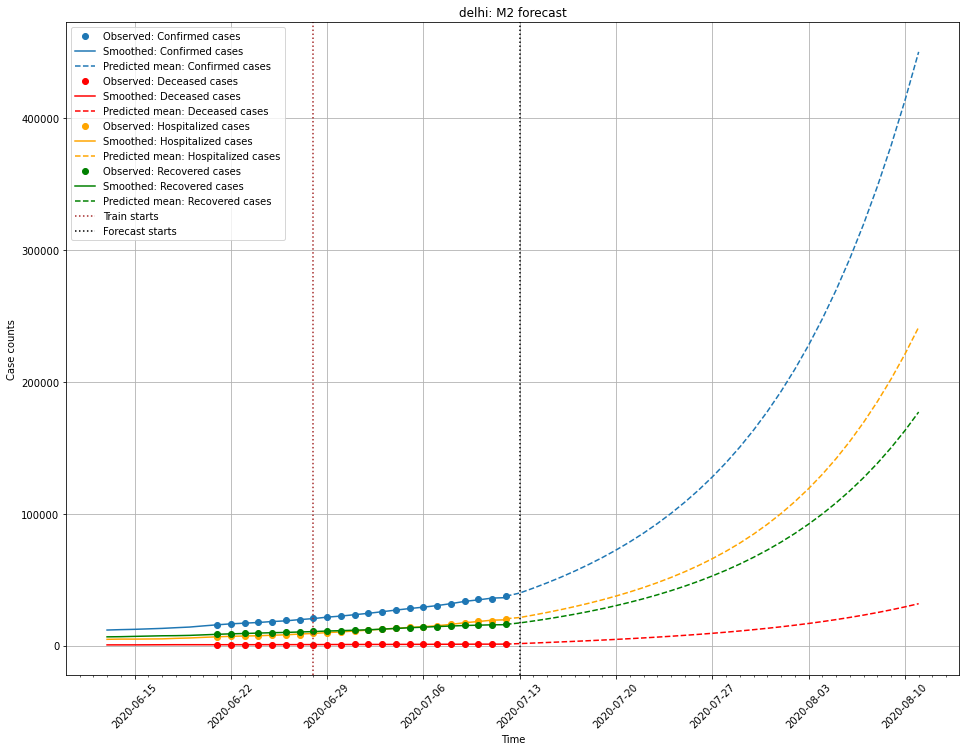

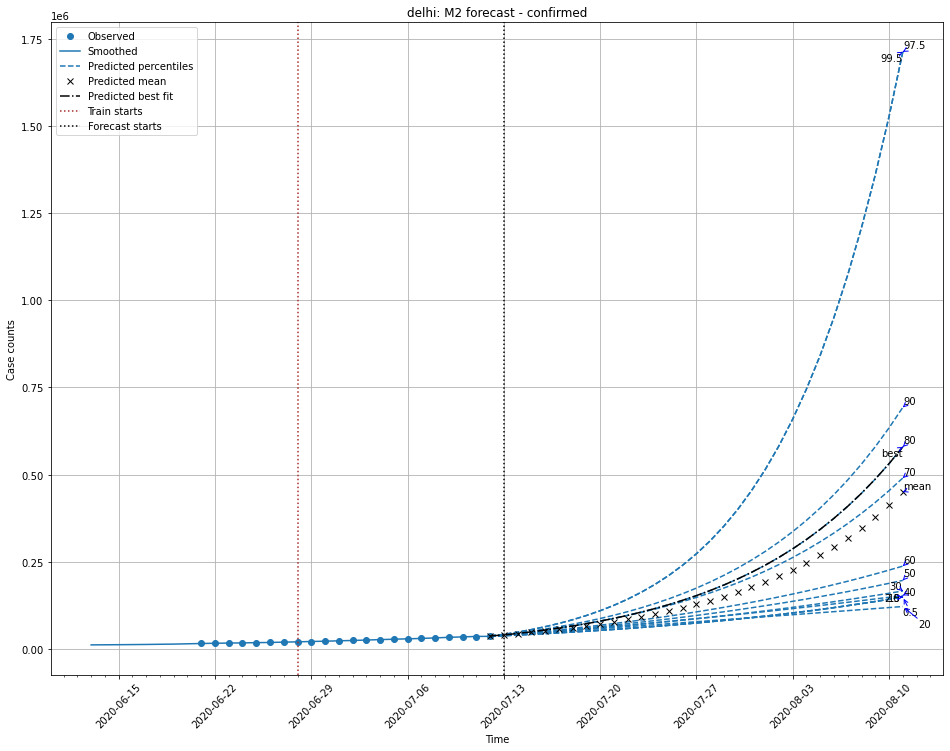

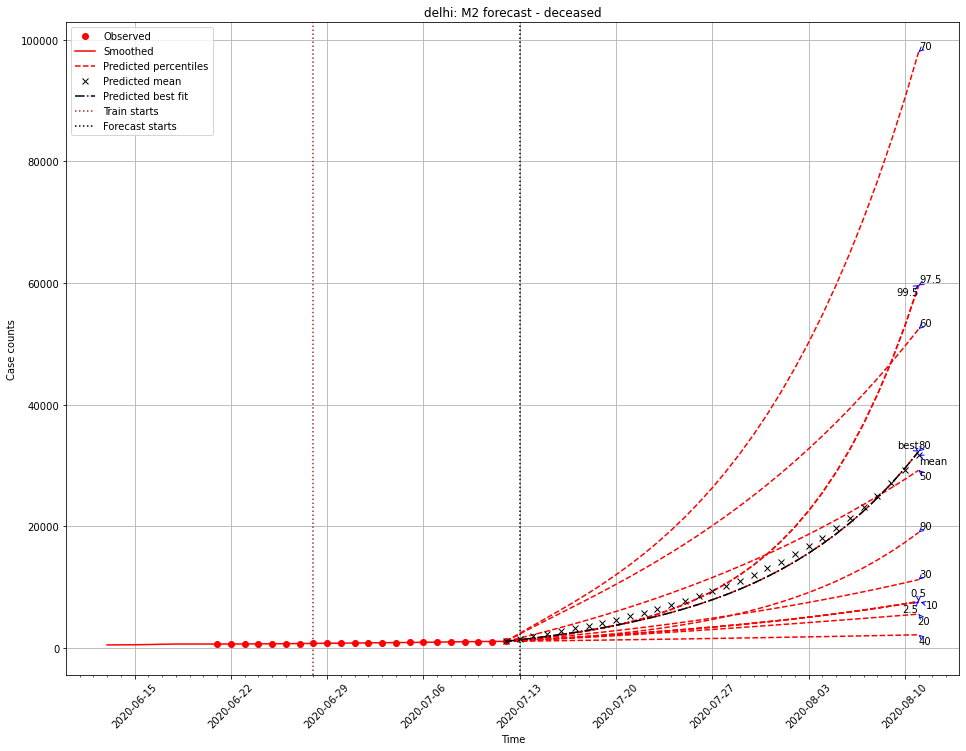

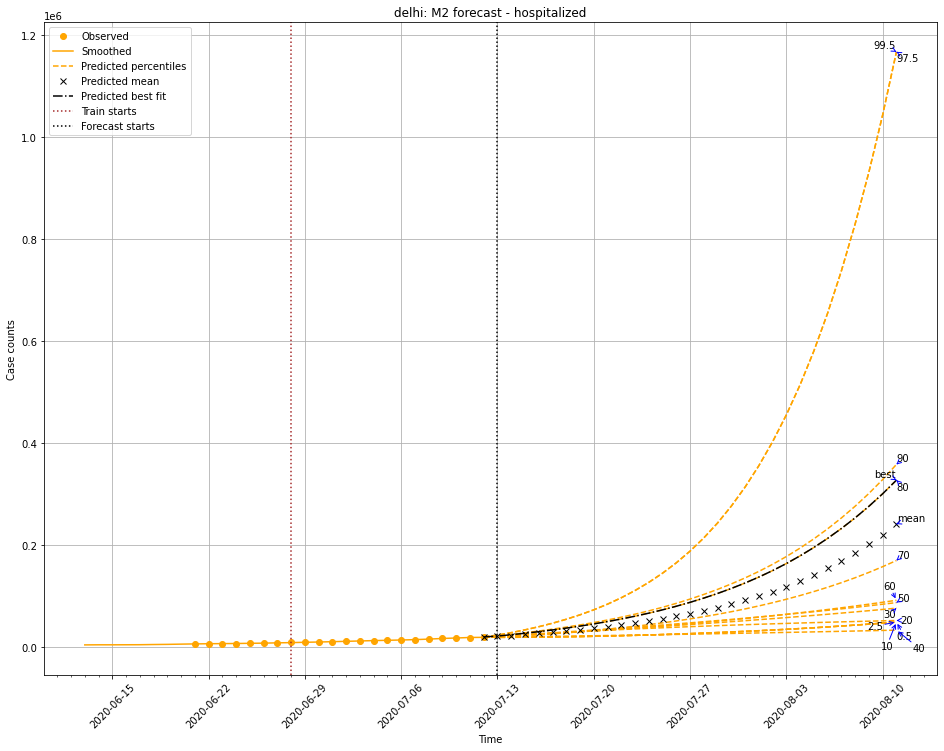

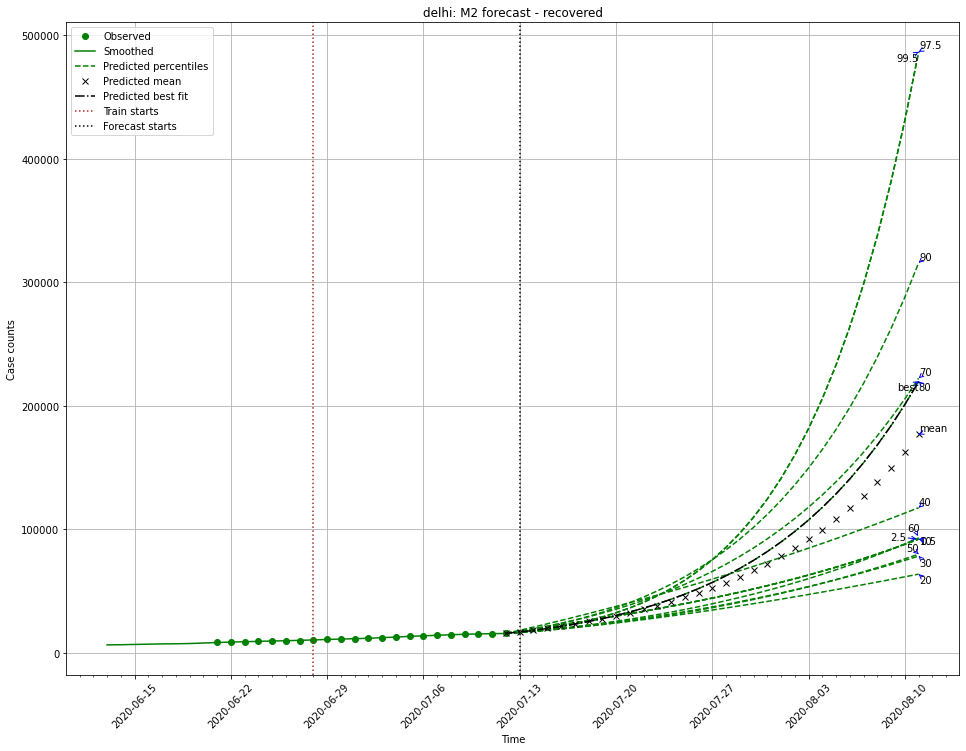

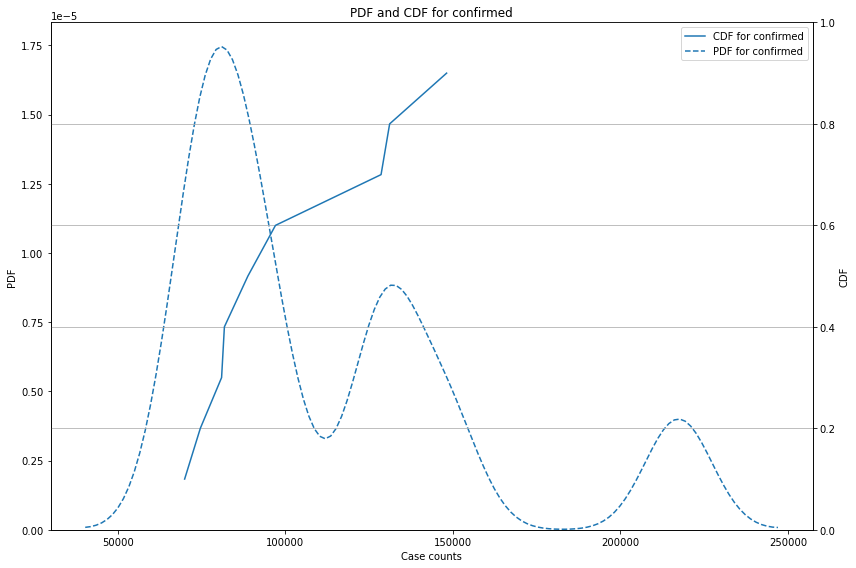

In [10]:
# NO EDIT CELL
outputs = current_session.build_models_and_generate_forecast()

### Output Interpretation & Troubleshooting

* <TODO:ADD> 

# Step 4: Planning and What-if Scenarios

* **Description**: Generate planning forecasts as per the specified configuration

* **Inputs**: 
    * region_name: REGION_NAME
        * valid region name
    * region_type: REGION_TYPE
        * valid region type from ['country','state','district']
    * uncertainty_config: UncertaintyConfig
        * planning level, confidence interval bounds, mean inclusion 
        * see <TODO:add links> for more details (default =mb.UNCERTAINTY_CONFIG)
    * scenarios_config: ScenarioConfig, optional
        * parameter choices/multipliers for various scenarios
        * see <TODO:add links> for more details (default =mb.SCENARIO_CONFIG)
    * model: ModelWrapperBase, optional 
        * model to be used for uncertainty generation 
    * planning_output_report_file: str, optional
        * filepath for the report that contains output needed for planning

    
* **Outputs**:
    * planning_artifact_list: list[str]
        * list of artifact files (e.g., plots, csvs, reports) generated  

### Input Choice Tips

* As before, there should really be no need to set parameters that are already set even though they are presented again
* There is also no need to change the output artifact filepaths 
* **Typical User Setup**: 
    * **Uncertainty Config:**
        * **planning_level**: 70 or 80 percentile is a good level to plan for, but this can be adjusted based on the stage of the pandemic. In early stages, a higher level might be required, while in mid to later stages, a lower level might suffice. 
        * **include_mean**: preferable to set it to true (default =true) so that it is shown in the plot
        * **confidence_interval**: needs to be set based on the how the information is likely to be consumed. Standard use is a 90% or 95% confidence interval (bounds are 5%-95% and 2.5%-97.5%) as long as the semantics are well understood by the end users. 
    
* **Expert User Setup**: 
    * If required, experts familiar with epidemiological parameters can also generate forecasts for other scenarios based on planning level. It is also possible to use a different model as the basis for the scenarios instead of the current one.  All the relevant input parameters and the associated information is described under "generate_planning_forecasts" in ModelBuildingParameters <TODO:ADDLinks>




In [11]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# ALREADY SET PARAMETERS
#current_session.set_param('region_type', <user_input:region_type>)
#current_session.set_param('region_name', <user_input:region_name>)


# MANDATORY PARAMETERS 
current_session.set_field('planning.ref_level', 80)
current_session.set_field('staffing.staffing_ratios_file', '../data/staffing_ratios.csv')

# OPTIONAL PARAMETERS 
#current_session.set_param('planning_output_report_file',<user_input:planning_output_report_file>)
# Uncertainty config
#current_session.set_param('uncertainty_config.include_mean',<user_input:uncertainty_config.include_mean>)
#current_session.set_param('uncertainty_config.confidence_interval.lower_bound',<user_input:uncertainty_config.confidence_interval.lower_bound>)
#current_session.set_param('uncertainty_config.confidence_interval.upper_bound',<user_input:uncertainty_config.confidence_interval.upper_bound>)


In [12]:
# EXPERT USER SET UP (PLEASE DO NOT EDIT UNLESS REALLY REQUIRED)
# EDIT CELL:

# OPTIONAL PARAMETERS FOR EXPERTS
# Any input parameter of generate_planning_outputs in ModelBuildingParameter.pdf can be adjusted similar to below example 

current_session.set_field('planning.rt_multiplier_list', [0.9, 1.1, 1.2])

[autoreload of model_building_utils_new failed: Traceback (most recent call last):
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/pydantic/main.py", line 281,

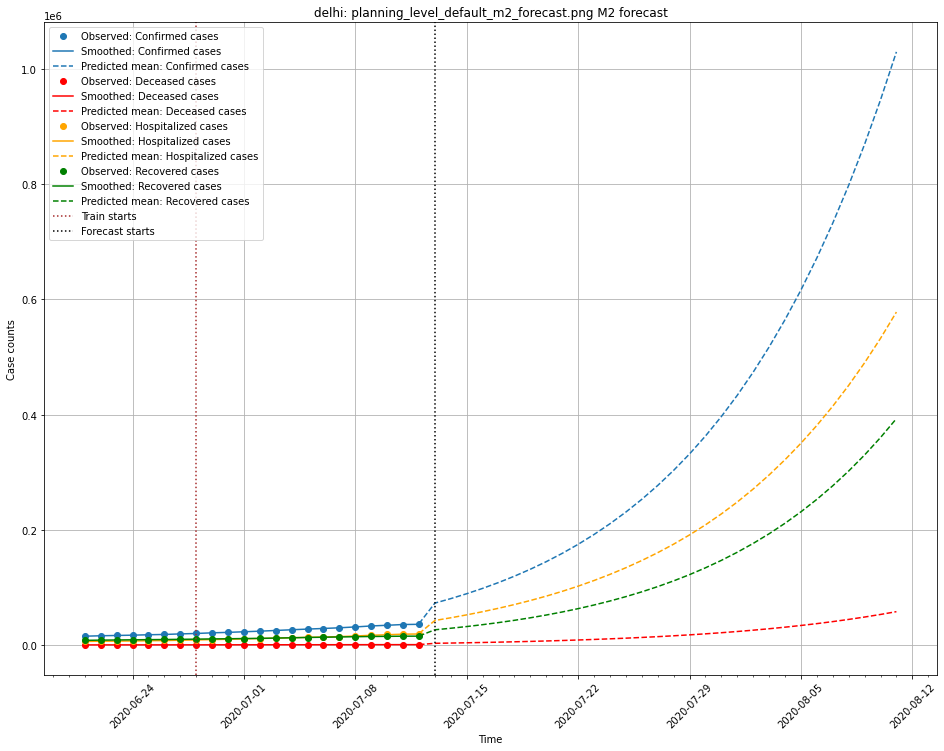

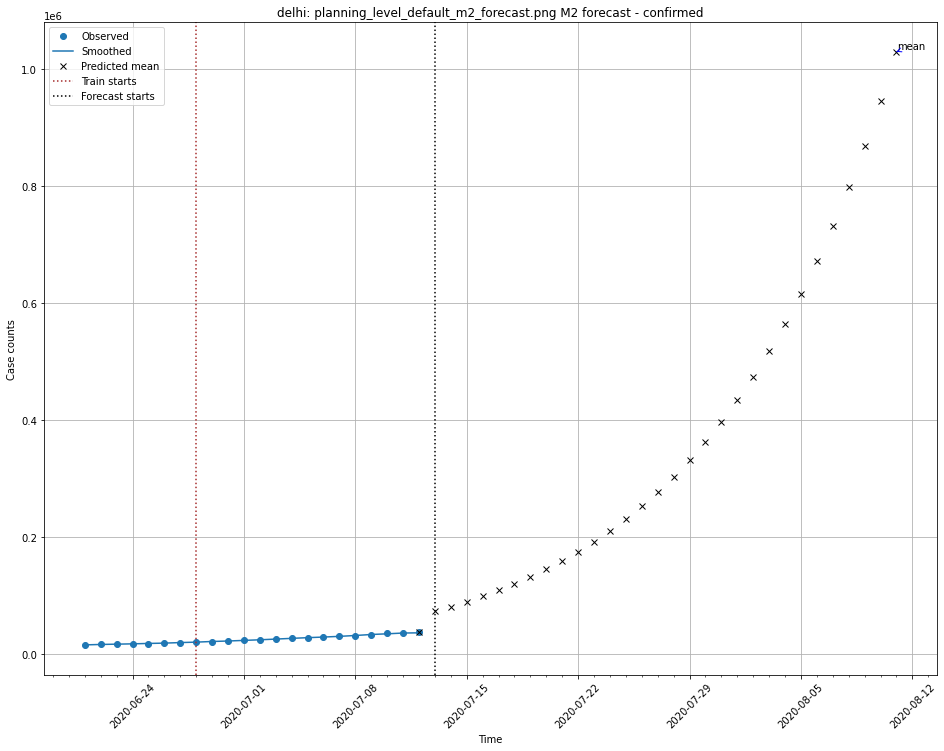

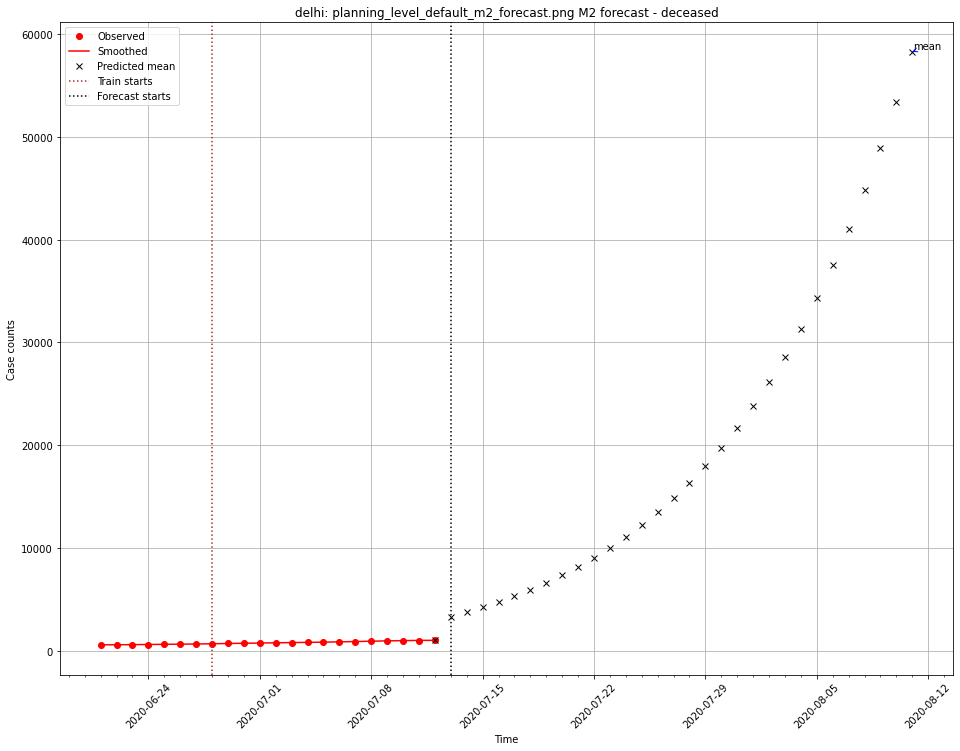

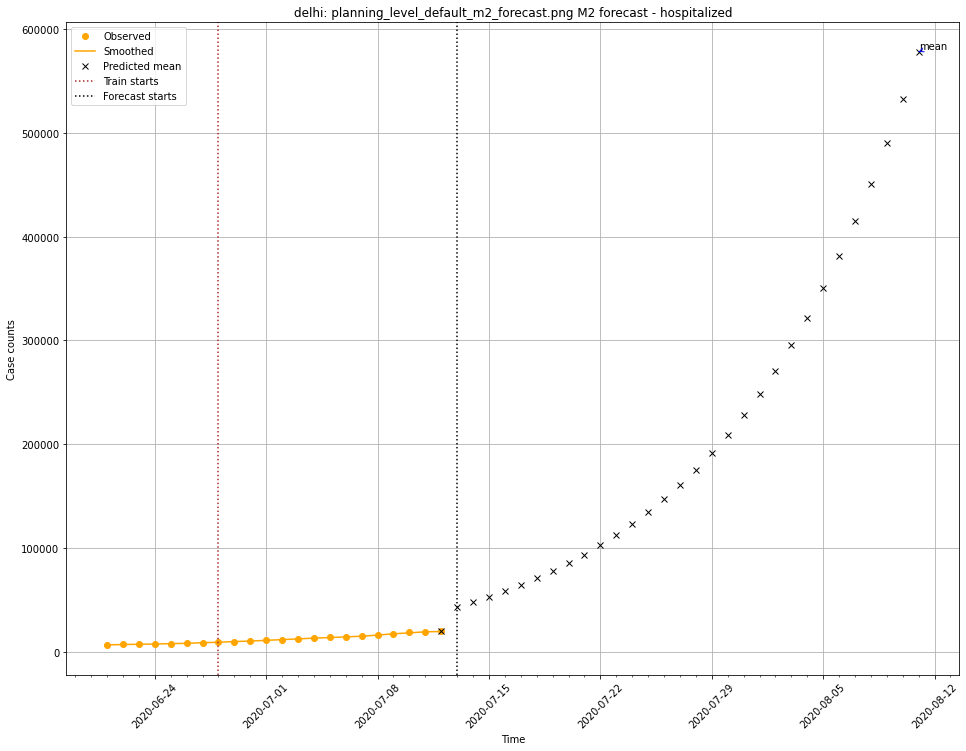

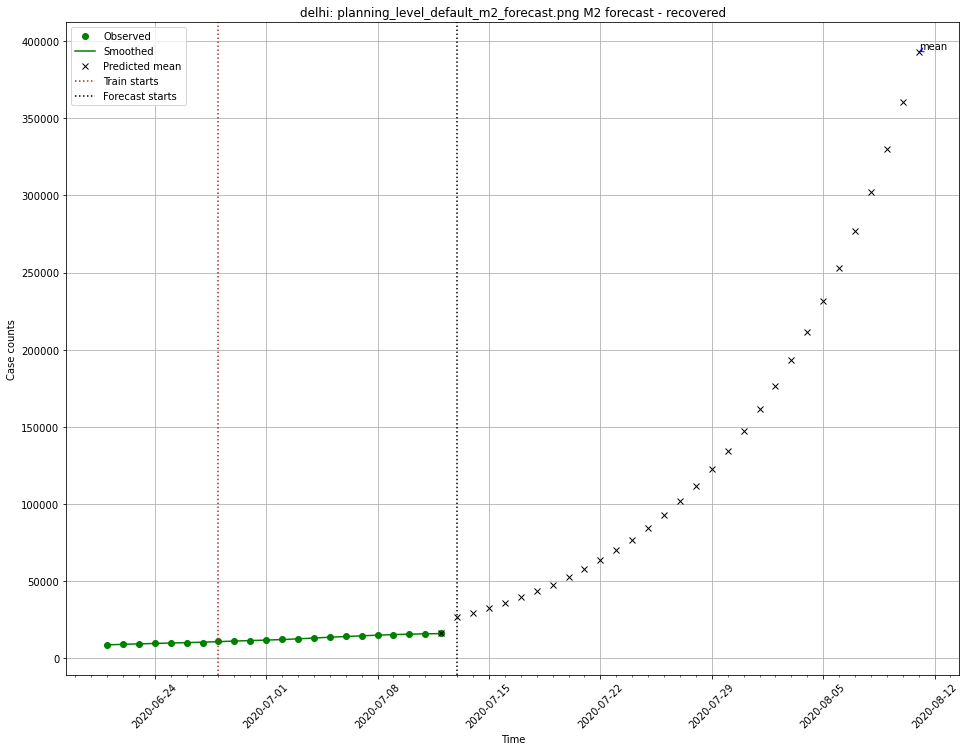

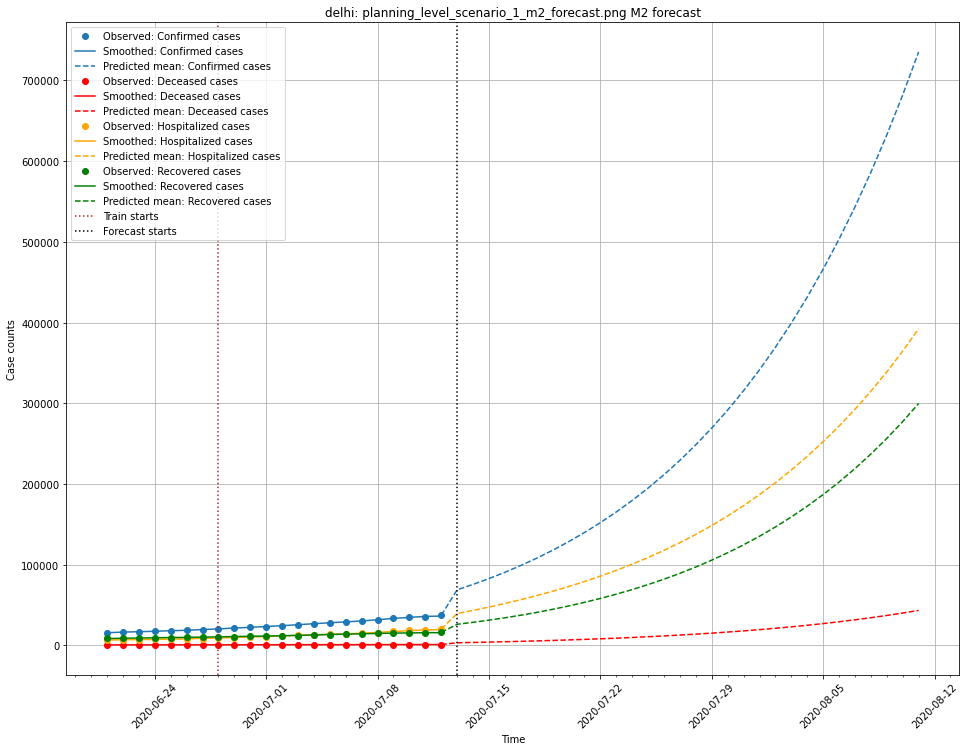

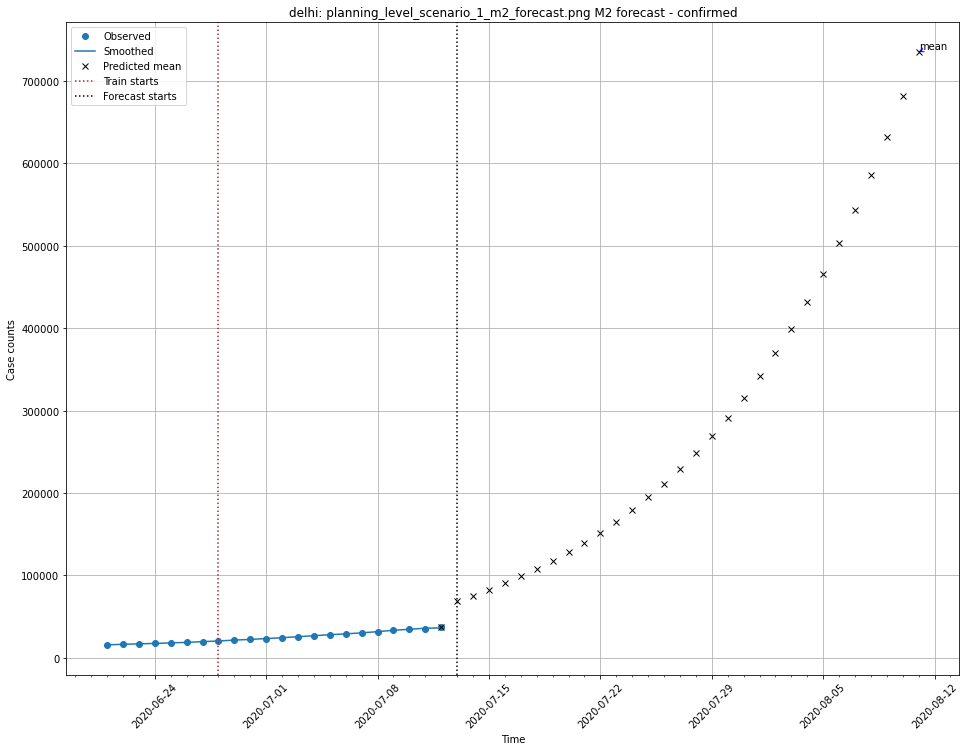

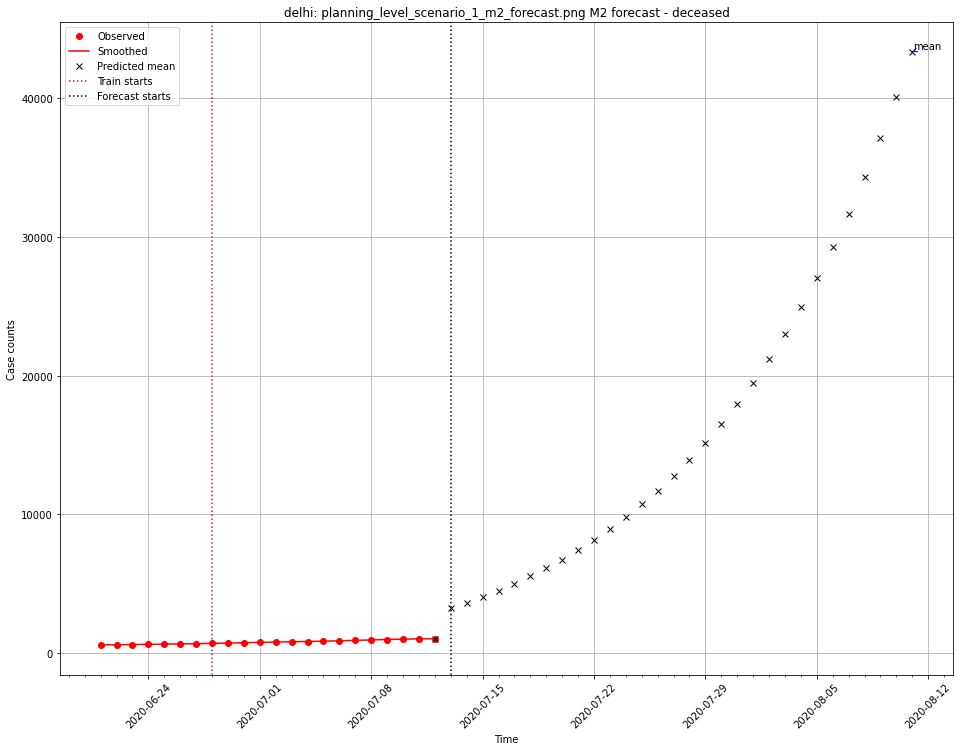

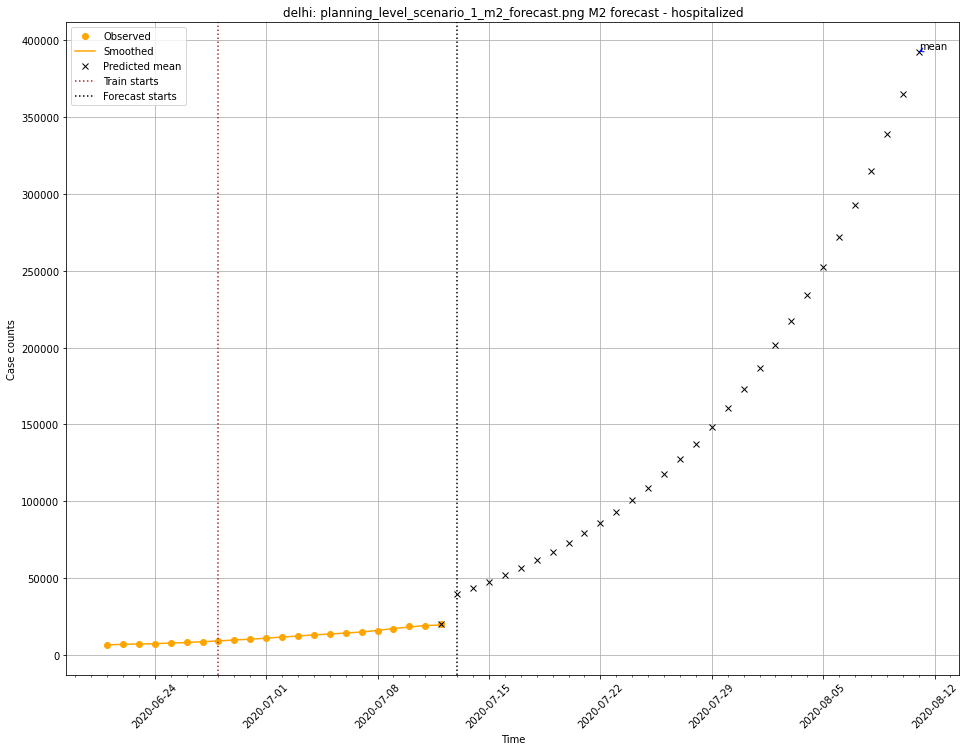

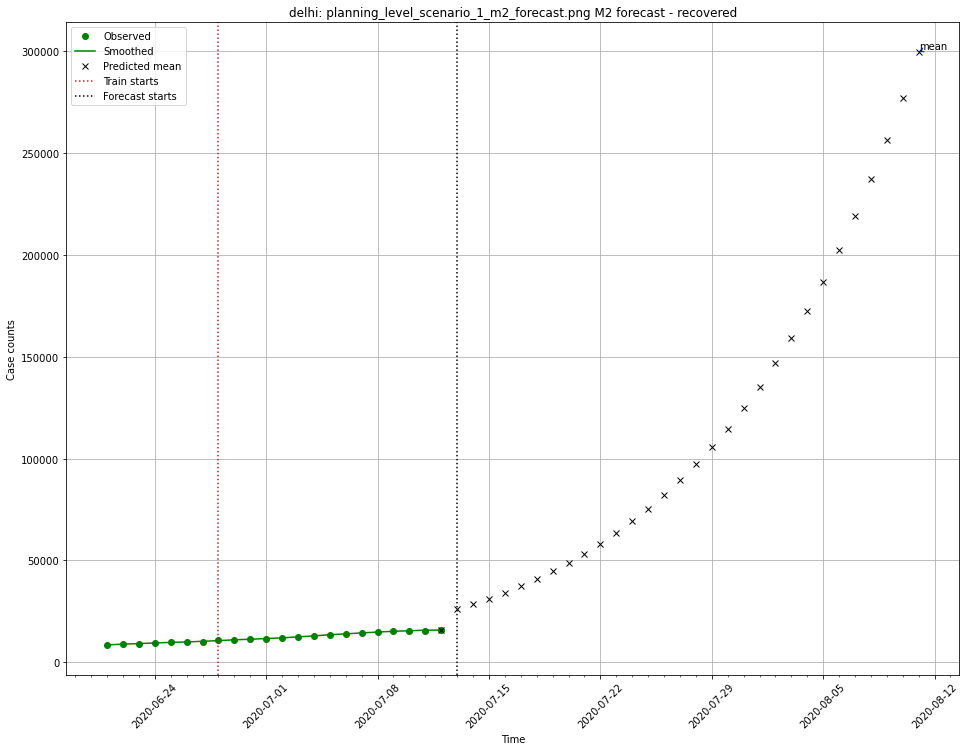

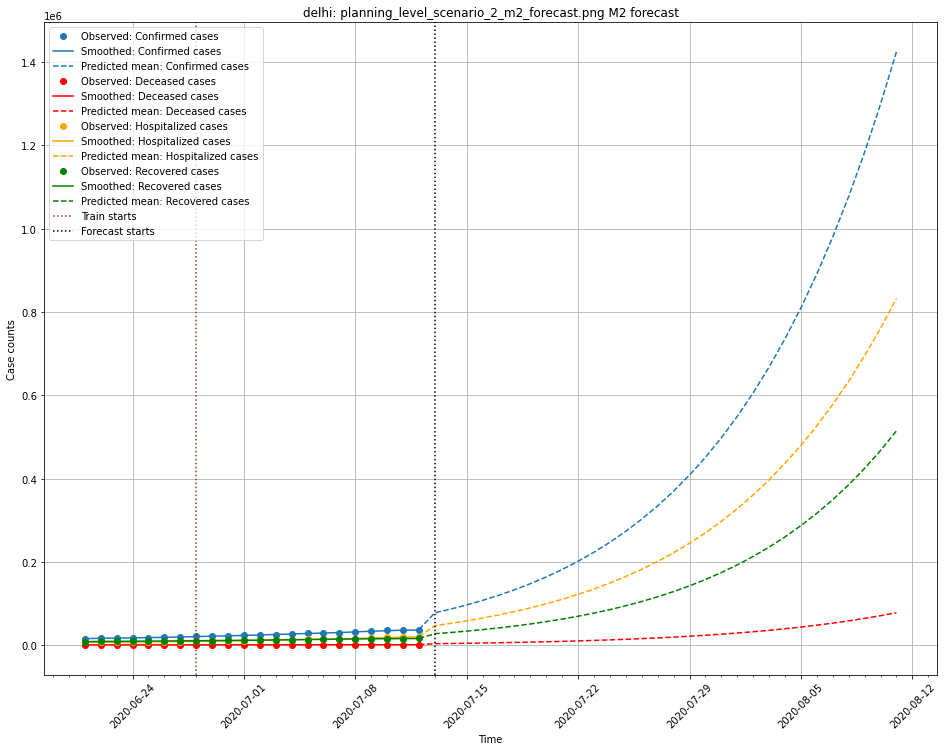

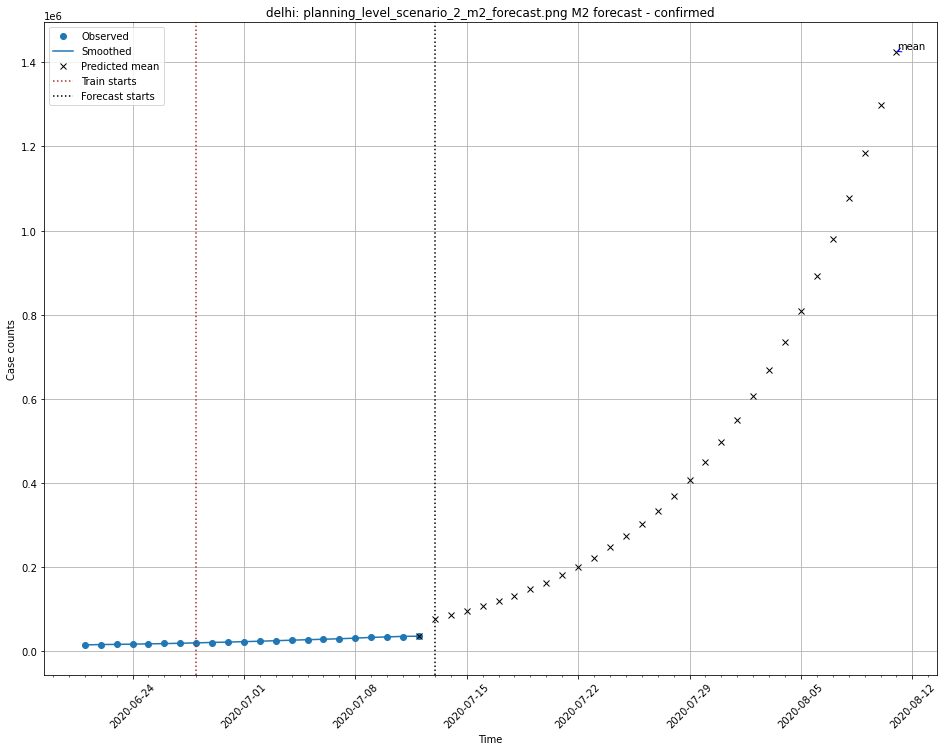

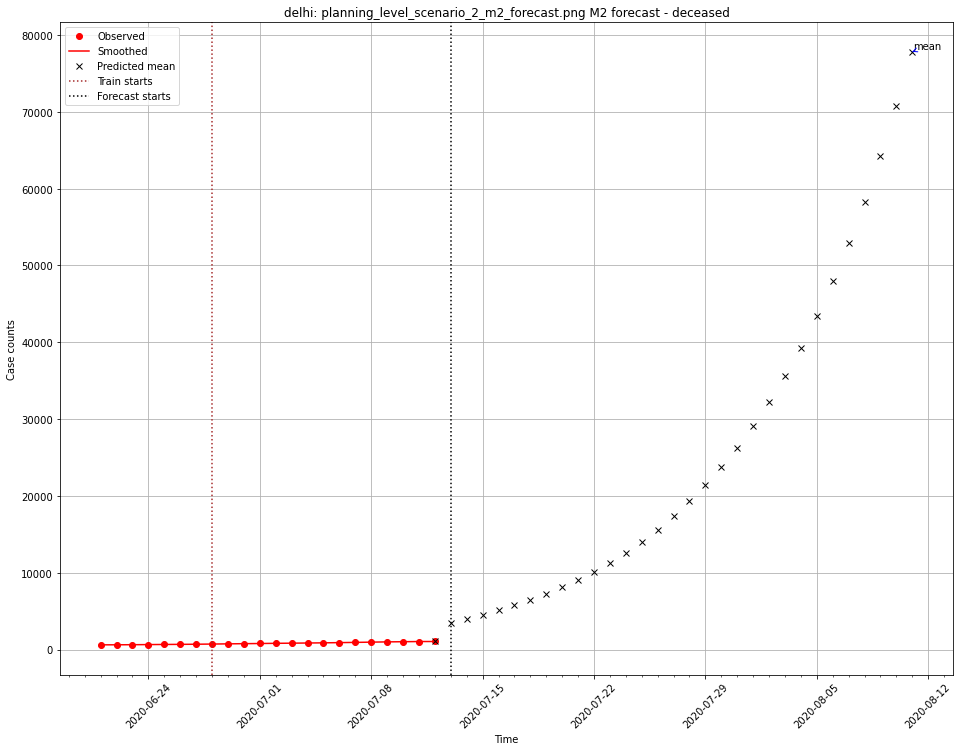

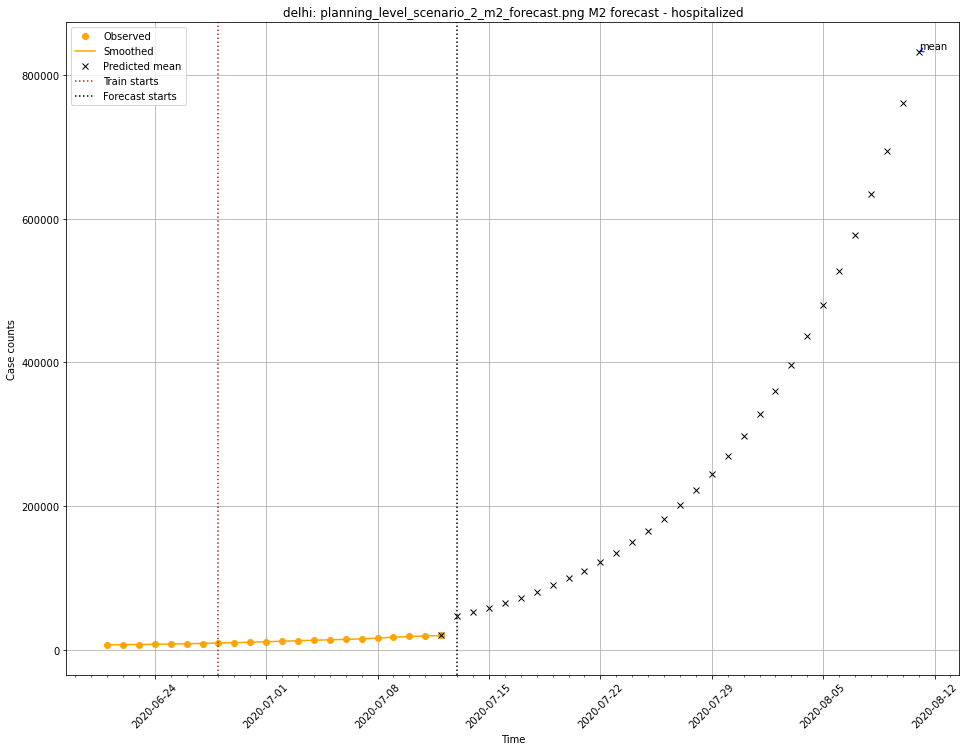

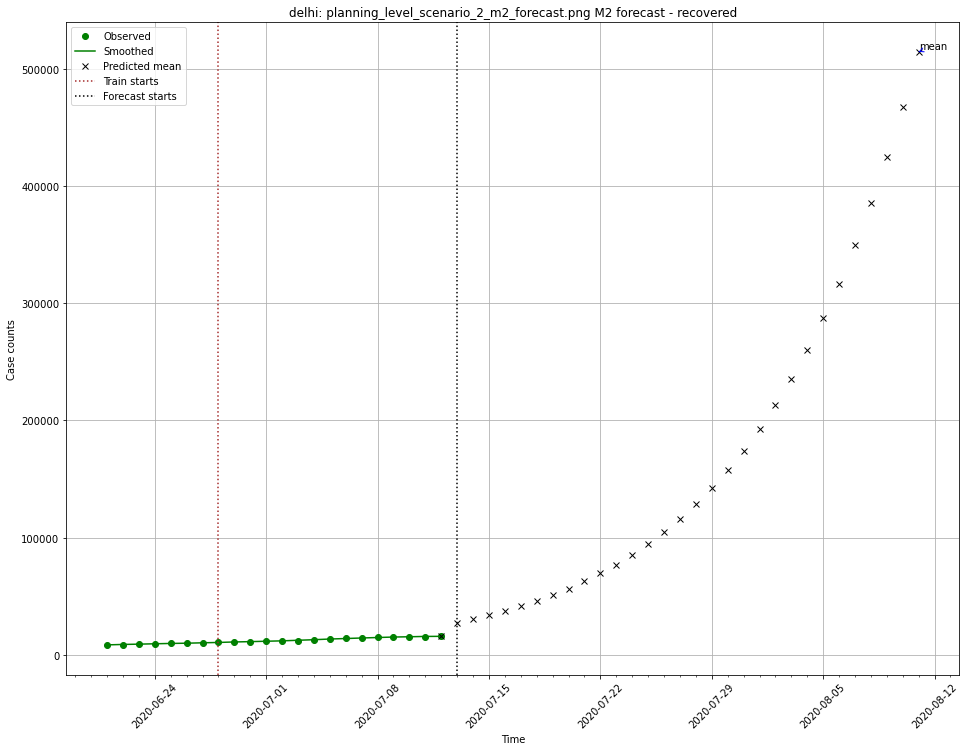

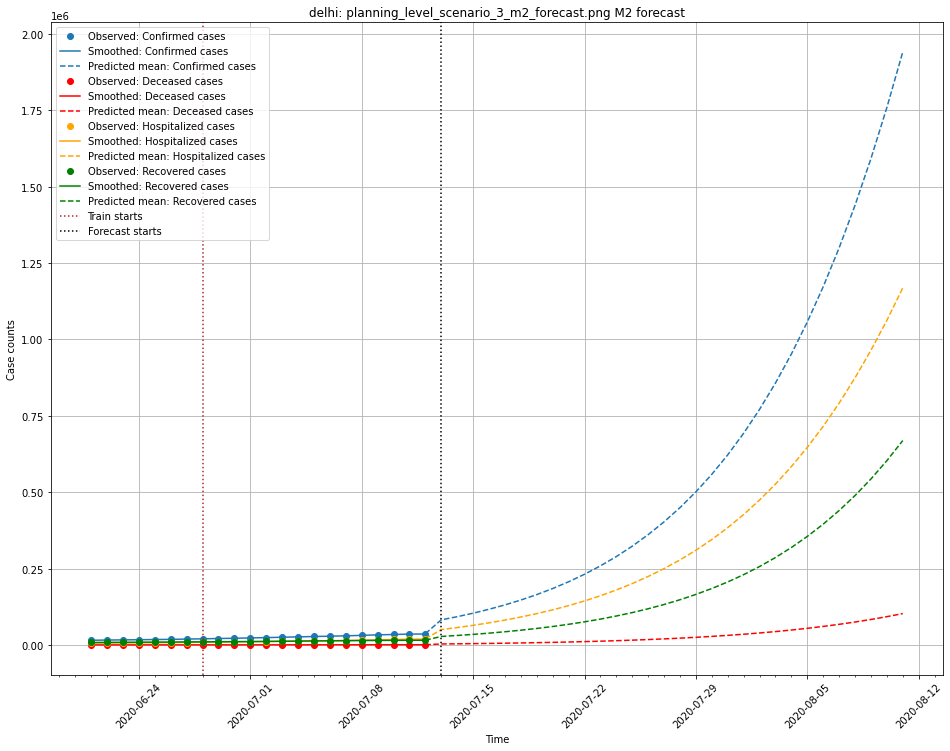

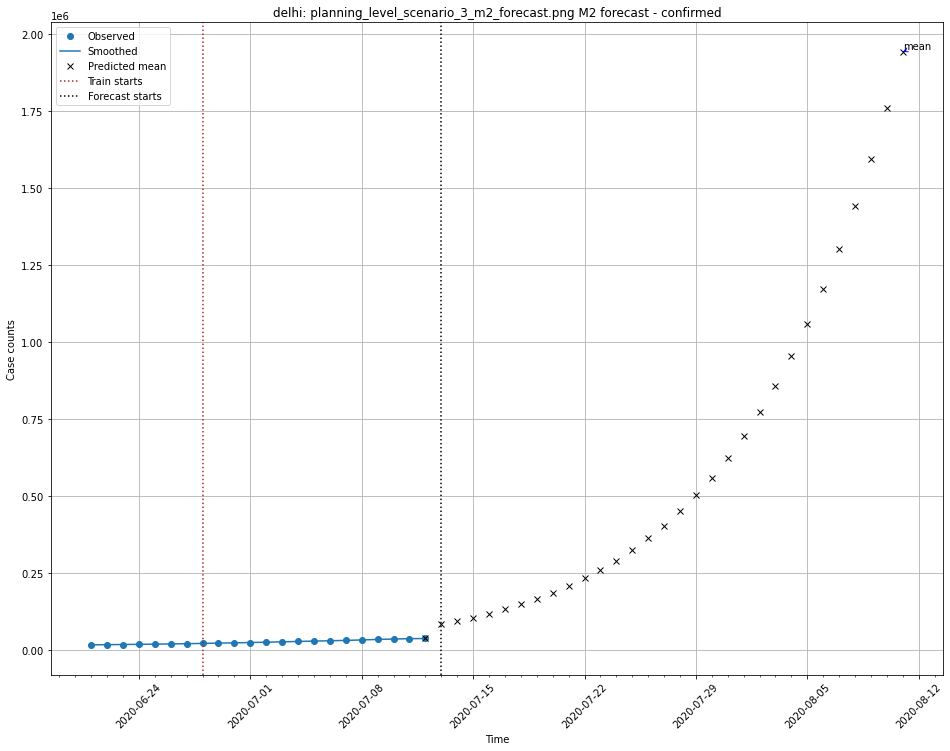

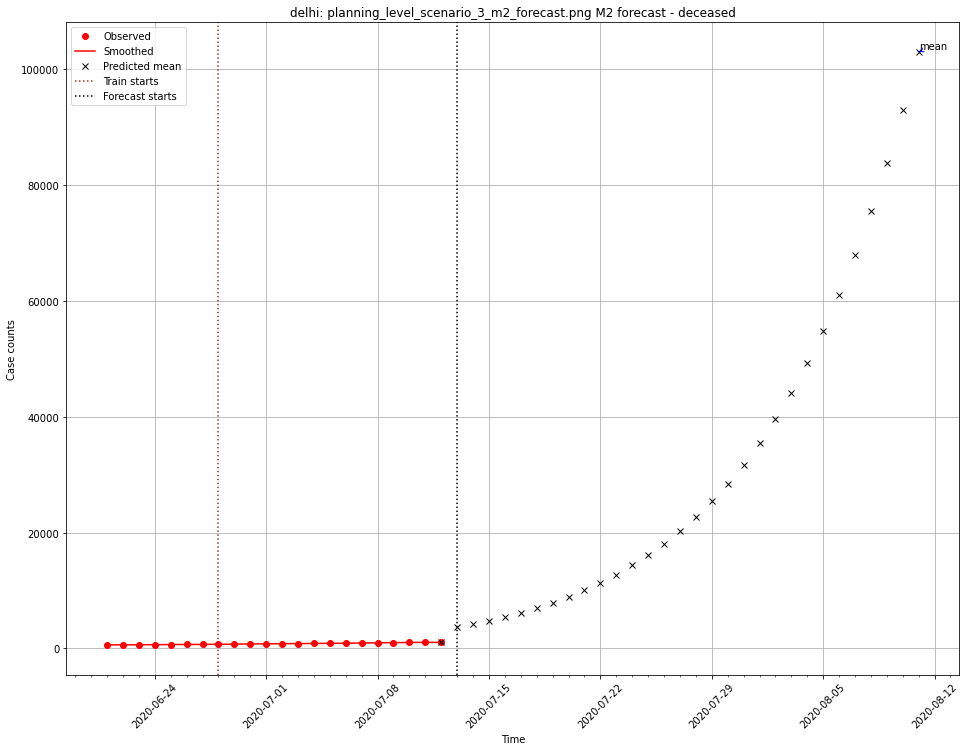

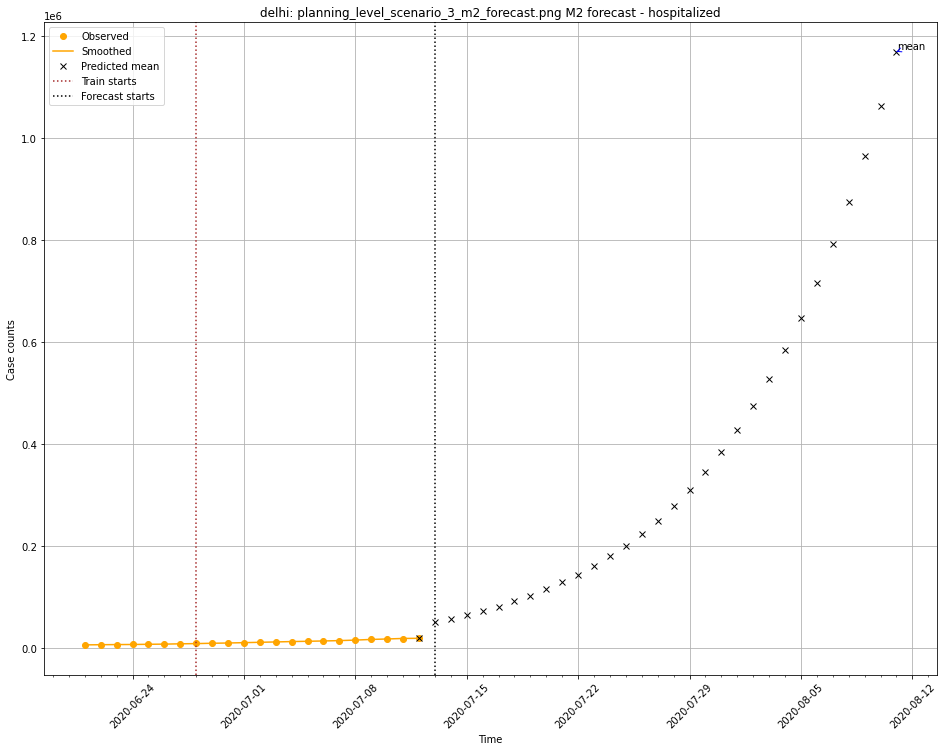

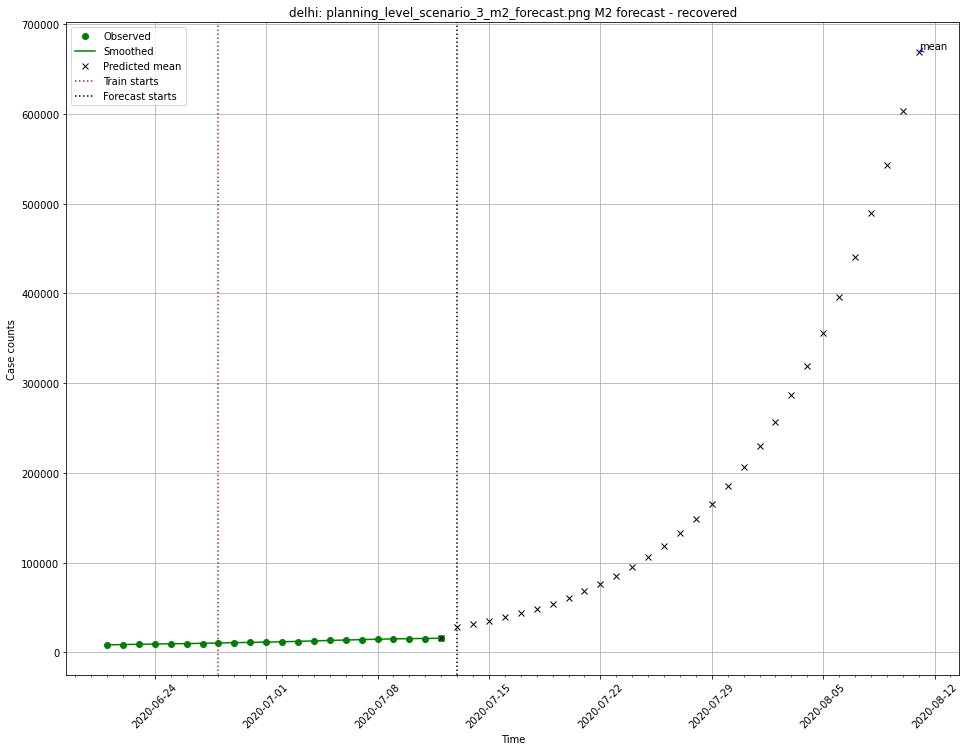

In [36]:
# NO EDIT CELL
planning_outputs = current_session.generate_planning_outputs()

### Output Interpretation & Troubleshooting

* * <TODO:ADD> After the implementation

# Step 5: View Current Forecast Outputs

* **Description**: Lists all the outputs and metadata of all the previous steps of model building session to review again if necessary

* **Inputs**: 
    * None    
* **Outputs**:
    * None 

In [38]:
# NO EDIT CELL
current_session.list_outputs()

Listing all the output artifacts from the session:

cleaned_case_count_file: cleaned_case_count_file

plot_case_count: plot_case_count

plot_M1_CARD: plot_M1_CARD

plot_M1_single_A: plot_M1_single_A

plot_M1_single_C: plot_M1_single_C

plot_M1_single_D: plot_M1_single_D

plot_M1_single_R: plot_M1_single_R

M1_model_params: M1_model_params

M1_beta_trials: M1_beta_trials

M1_param_ranges: M1_param_ranges

M1_train_config: M1_train_config

M1_test_config: M1_test_config

M2_full_output_forecast_file: M2_full_output_forecast_file

plot_M2_CARD: plot_M2_CARD

plot_M2_single_A: plot_M2_single_A

plot_M2_single_C: plot_M2_single_C

plot_M2_single_D: plot_M2_single_D

plot_M2_single_R: plot_M2_single_R

plot_M2_forecast_CARD: plot_M2_forecast_CARD

plot_M2_forecast_single_A: plot_M2_forecast_single_A

plot_M2_forecast_single_C: plot_M2_forecast_single_C

plot_M2_forecast_single_D: plot_M2_forecast_single_D

plot_M2_forecast_single_R: plot_M2_forecast_single_R

M2_model_params: M2_model_params

# Model Building  Detailed Report -  state - delhi  

## Training, Evaluation and Forecast Set up

### Data Source

direct_csv - []()

### Time Intervals for Training, Evaluation and Forecast
```yaml
{   'direct': {   'forecast_end_date': '8/11/20',
                  'forecast_run_day': '7/12/20',
                  'forecast_start_date': '7/13/20',
                  'plot_start_date_m1': '6/13/20',
                  'plot_start_date_m2': '6/21/20',
                  'test_end_date': '7/12/20',
                  'test_run_day': '7/4/20',
                  'test_start_date': '7/5/20',
                  'train1_end_date': '7/4/20',
                  'train1_run_day': '6/19/20',
                  'train1_start_date': '6/20/20',
                  'train2_end_date': '7/12/20',
                  'train2_run_day': '6/27/20',
                  'train2_start_date': '6/28/20'},
    'offset_based': {   'forecast_period': 30,
                        'plot_buffer': 7,
                        'reference_day': '7/12/20',
                        'test_period': 7,
                        'train_period': 14}}
```
### Training Configuration 

Model Class: homogeneous_ensemble

Search Configuration:

```yaml
{   'child_model': {'max_evals': 10},
    'ensemble_model': {'max_evals': 10},
    'time_split_for_child_training': 0.5}
```

```yaml

```
Training Loss Function: 
```yaml

```
Evaluation Loss Function: 
```yaml

```
Forecast Percentiles: 

## Training and Evaluation - Model M1 Results

Parameter values and ranges: 



Beta: 7.550299926921511

Plots:

![Round 1 - Training and Evaluation Plot](../outputs/del_outputs/m1.png)

![Round 1 - Training and Evaluation Plot - Confirmed ](../outputs/del_outputs/m1_confirmed.png)

![Round 1 - Training and Evaluation Plot - Active ](../outputs/del_outputs/m1_hospitalized.png)

![Round 1 - Training and Evaluation Plot - Recovered ](../outputs/del_outputs/m1_recovered.png)

![Round 1 - Training and Evaluation Plot - Deceased ](../outputs/del_outputs/m1_deceased.png)

Loss values:



## Training and Evaluation - Model M2 Results

Parameter values and ranges:



Beta: 9.69995610578166

Plots:

![Round 2 - Training Plot](../outputs/del_outputs/m2.png)

![Round 2 - Training Plot - Confirmed ](../outputs/del_outputs/m2_confirmed.png)

![Round 2 - Training Plot - Active ](../outputs/del_outputs/m2_hospitalized.png)

![Round 2- Training Plot - Recovered ](../outputs/del_outputs/m2_recovered.png)

![Round 2- Training Plot - Deceased ](../outputs/del_outputs/m2_deceased.png)

Loss values:



Representative trials for various percentiles:



Forecasts:

![Round 2 - Forecast Plot](../outputs/del_outputs/m2_forecast.png)

![Round 2 - Forecast Plot - Confirmed ](../outputs/del_outputs/m2_forecast_confirmed.png)

![Round 2 - Forecast Plot - Active ](../outputs/del_outputs/m2_forecast_hospitalized.png)

![Round 2- Forecast Plot - Recovered ](../outputs/del_outputs/m2_forecast_recovered.png)

![Round 2- Forecast Plot - Deceased ](../outputs/del_outputs/m2_forecast_deceased.png)

## Planning  Forecast

* Planning Variable:  
* Planning Date:  

![Planning Date Forecast Distribution ](../outputs/del_outputs/m2_distribution.png)

## Main Forecast Output

Forecast CSV file: [Forecast csv]()

## Additional Artifacts 

* M1 Ensemble model: 
* M1 Beta exploration: 
* M2 Ensemble model: 
* M2 Beta exploration: 


# Planning Report -  state - delhi  


## Planning Set up

* Planning Variable:  
* Planning Date:  

* Planning Uncertainty Config: 
```yaml

```

* What if  Scenarios - R0 Multipliers: 

##  Model Parameters

* Planning Level Model: 
```yaml

```

##  Planning Forecast
  
![Planning Forecast Plot](../outputs/del_outputs/planning_level_default_m2_forecast.png)


### Staffing Matrix




##  What-if Scenario Forecasts

What if  Scenarios - R0: 

![Planning Scenario 1 Forecast Plot](../outputs/del_outputs/planning_level_scenario_1_m2_forecast.png)

![Planning Scenario 2 Forecast Plot](../outputs/del_outputs/planning_level_scenario_2_m2_forecast.png)

![Planning Scenario 3 Forecast Plot](../outputs/del_outputs/planning_level_scenario_3_m2_forecast.png)

###  Staffing Matrices








## Main Forecast Output

Forecast CSV file: 


# Step 6:  Publish Current Forecast Outputs

* **Description**: Sets the forecast publish status and add text comments or questions on the model building session and logs this on MLFlow
* **Inputs**: 
    * publish_status: bool
        * true for publishing and false otherwise
    * comments: str
        * short note on key observations and questions on the model building session 
* **Outputs**:
    * None 
    

### Input Choice Tips

* **publish_status**: choose true if the forecast generated seems good enough
* **comments**: notes related to data, input choices, trends, questions on model choices. A detailed list of items to consider while reviewing the model building process is provided in ForecastModelReview.pdf <TODO:ADDLinks> 

In [ ]:
# EDIT CELL: SET INPUT VALUES AS REQUIRED

# MANDATORY PARAMETERS 
current_session.set_param('publish_status',True)

# OPTIONAL PARAMETERS 
current_session.set_param('comments','all good so far')
current_session.set_param('questions','What is the R0?')

In [ ]:
# NO EDIT CELL
current_session.log_session()

### Output Interpretation & Troubleshooting

* <TODO:ADD> any MLFlow problems - e.g., if internet is slow or disconnected, what happens?

## 